Faze 3 

Svm for Numbers

In [1]:
import os
import joblib
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from tqdm import tqdm

dataset_path = Path("num_ds")

label_correction = {
    "43-anewfive": "five",
    "38-five": "five"
}

features = []
labels = []

for folder in tqdm(os.listdir(dataset_path)):
    full_path = dataset_path / folder
    if not os.path.isdir(full_path):
        continue

    label = folder.split('-', 1)[-1]
    if folder in label_correction:
        label = label_correction[folder]

    for file in os.listdir(full_path):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = full_path / file
        try:
            img = Image.open(img_path).convert("L").resize((64, 64))
            img_arr = np.array(img) / 255.0

            hog_features = hog(img_arr, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys')
            
            features.append(hog_features)
            labels.append(label)
        except Exception as e:
            print(f"error {img_path}: {e}")

X = np.array(features)
y = np.array(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

model = SVC(kernel='rbf', C=1000, gamma='scale')
model.fit(X_pca, y)


joblib.dump(model, "svm_digit_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
print("Model, scaler, and PCA saved")



100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Model, scaler, and PCA saved


Dt For Letters

In [14]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
from tqdm import tqdm
import cv2
from sklearn.decomposition import PCA

dataset_path = Path("letter_ds")  

features = []
labels = []

def zone_features(binary_img, zones=(3, 3)):
    h, w = binary_img.shape
    zh, zw = h // zones[0], w // zones[1]
    zone_feats = []
    for i in range(zones[0]):
        for j in range(zones[1]):
            zone = binary_img[i*zh:(i+1)*zh, j*zw:(j+1)*zw]
            zone_feats.append(int(np.any(zone))) 
    return zone_feats

def pixel_density(binary_img):
    total_pixels = binary_img.size
    black_pixels = np.sum(binary_img == 255)
    ratio = black_pixels / total_pixels
    return int(ratio > 0.2)

def background_ratio(binary_img):
    white = np.sum(binary_img == 0)
    black = np.sum(binary_img == 255)
    if black == 0:
        return 2
    ratio = white / black
    if ratio < 0.5:
        return 0
    elif ratio < 1.5:
        return 1
    else:
        return 2

def centroid_zone(binary_img):
    M = cv2.moments(binary_img)
    if M["m00"] == 0:
        return [1, 1]
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    h, w = binary_img.shape
    return [
        cx * 3 // w,  
        cy * 3 // h   
    ]

def aspect_ratio(binary_img):
    h, w = binary_img.shape
    return round(h / w, 2)

def top_middle_bottom_density(binary_img):
    h = binary_img.shape[0]
    thirds = h // 3
    top = np.sum(binary_img[:thirds, :] == 255)
    middle = np.sum(binary_img[thirds:2*thirds, :] == 255)
    bottom = np.sum(binary_img[2*thirds:, :] == 255)
    return [top, middle, bottom]

def vertical_horizontal_lines(binary_img):
    vertical = np.max(np.sum(binary_img == 255, axis=0))
    horizontal = np.max(np.sum(binary_img == 255, axis=1))
    return [int(vertical > binary_img.shape[0] * 0.8), int(horizontal > binary_img.shape[1] * 0.8)]

def count_curves(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    arc_count = 0
    for cnt in contours:
        if cv2.arcLength(cnt, True) > 50:
            arc_count += 1
    return arc_count

def detect_dots(binary_img):
    num_labels, labels_im = cv2.connectedComponents(binary_img)
    height = binary_img.shape[0]
    top_dot = 0
    bottom_dot = 0
    for i in range(1, num_labels):
        ys, xs = np.where(labels_im == i)
        if len(ys) == 0:
            continue
        cy = np.mean(ys)
        if cy < height / 3:
            top_dot += 1
        elif cy > 2 * height / 3:
            bottom_dot += 1
    return [top_dot, bottom_dot]

for folder in tqdm(os.listdir(dataset_path)):
    folder_path = dataset_path / folder
    if not os.path.isdir(folder_path):
        continue

    label = folder.split('-', 1)[-1]

    for file in os.listdir(folder_path):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = folder_path / file
        try:
            img = Image.open(img_path).convert("L")
            img_arr = np.array(img)
            _, binary = cv2.threshold(img_arr, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            f = []
            f += zone_features(binary, zones=(3, 3))
            f.append(pixel_density(binary))
            f.append(background_ratio(binary))
            f += centroid_zone(binary)
            f.append(aspect_ratio(binary))
            f += top_middle_bottom_density(binary)
            f += vertical_horizontal_lines(binary)
            f.append(count_curves(binary))
            f += detect_dots(binary)

            features.append(f)
            labels.append(label)
        except Exception as e:
            print(f" error {img_path}: {e}")

le = LabelEncoder()
y = le.fit_transform(labels)
X = np.array(features)

pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
#clf.fit(X_pca,y)
clf.fit(X, y)

joblib.dump(clf, "letter_tree_model.pkl")
joblib.dump(le, "letter_label_encoder.pkl")
print("saved")
##########################


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:05<00:00,  5.88it/s]


saved


Faze 4

In [15]:
import os
import joblib
import numpy as np
from PIL import Image
from pathlib import Path
import cv2
from tqdm import tqdm
from skimage.feature import hog

svm_model = joblib.load("svm_digit_model.pkl")
scaler = joblib.load("scaler.pkl")
pca = joblib.load("pca.pkl")
letter_model = joblib.load("letter_tree_model.pkl")
letter_encoder = joblib.load("letter_label_encoder.pkl")

base_path = Path("components_final_merged")

def zone_features(binary_img, zones=(3, 3)):
    h, w = binary_img.shape
    zh, zw = h // zones[0], w // zones[1]
    zone_feats = []
    for i in range(zones[0]):
        for j in range(zones[1]):
            zone = binary_img[i*zh:(i+1)*zh, j*zw:(j+1)*zw]
            zone_feats.append(int(np.any(zone)))
    return zone_feats

def pixel_density(binary_img):
    total_pixels = binary_img.size
    black_pixels = np.sum(binary_img == 255)
    ratio = black_pixels / total_pixels
    return int(ratio > 0.2)

def background_ratio(binary_img):
    white = np.sum(binary_img == 0)
    black = np.sum(binary_img == 255)
    if black == 0:
        return 2
    ratio = white / black
    if ratio < 0.5:
        return 0
    elif ratio < 1.5:
        return 1
    else:
        return 2

def centroid_zone(binary_img):
    M = cv2.moments(binary_img)
    if M["m00"] == 0:
        return [1, 1]
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    h, w = binary_img.shape
    return [cx * 3 // w, cy * 3 // h]

def aspect_ratio(binary_img):
    h, w = binary_img.shape
    return round(h / w, 2)

def top_middle_bottom_density(binary_img):
    h = binary_img.shape[0]
    thirds = h // 3
    top = np.sum(binary_img[:thirds, :] == 255)
    middle = np.sum(binary_img[thirds:2*thirds, :] == 255)
    bottom = np.sum(binary_img[2*thirds:, :] == 255)
    return [top, middle, bottom]

def vertical_horizontal_lines(binary_img):
    vertical = np.max(np.sum(binary_img == 255, axis=0))
    horizontal = np.max(np.sum(binary_img == 255, axis=1))
    return [int(vertical > binary_img.shape[0] * 0.8), int(horizontal > binary_img.shape[1] * 0.8)]

def count_curves(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    arc_count = 0
    for cnt in contours:
        if cv2.arcLength(cnt, True) > 50:
            arc_count += 1
    return arc_count

def detect_dots(binary_img):
    num_labels, labels_im = cv2.connectedComponents(binary_img)
    height = binary_img.shape[0]
    top_dot = 0
    bottom_dot = 0
    for i in range(1, num_labels):
        ys, xs = np.where(labels_im == i)
        if len(ys) == 0:
            continue
        cy = np.mean(ys)
        if cy < height / 3:
            top_dot += 1
        elif cy > 2 * height / 3:
            bottom_dot += 1
    return [top_dot, bottom_dot]

output_lines = []

for folder in tqdm(sorted(os.listdir(base_path), key=lambda x: int(x))):
    folder_path = base_path / folder
    if not os.path.isdir(folder_path):
        continue

    components = sorted(
        [f for f in os.listdir(folder_path) if f.startswith("component_") and f.endswith(".png")],
        key=lambda x: int(x.split("_")[1].split(".")[0])
    )

    plate = []

    for file in components:
        img_path = folder_path / file
        try:
            img = Image.open(img_path).convert("L")
            img_arr = np.array(img)

            if file == "component_3.png":
                _, binary = cv2.threshold(img_arr, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                f = []
                f += zone_features(binary, zones=(3, 3))
                f.append(pixel_density(binary))
                f.append(background_ratio(binary))
                f += centroid_zone(binary)
                f.append(aspect_ratio(binary))
                f += top_middle_bottom_density(binary)
                f += vertical_horizontal_lines(binary)
                f.append(count_curves(binary))
                f += detect_dots(binary)

                pred_idx = letter_model.predict([f])[0]
                pred = letter_encoder.inverse_transform([pred_idx])[0]

            else:
                img_resized = img.resize((64, 64))
                img_norm = np.array(img_resized) / 255.0
                hog_feat = hog(img_norm, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys')
                img_scaled = scaler.transform([hog_feat])
                img_pca = pca.transform(img_scaled)
                pred = svm_model.predict(img_pca)[0]

            plate.append(pred)
        except Exception as e:
            print(f"error {img_path}: {e}")
            plate.append("?")

    line = f"{folder}," + ",".join(plate)
    output_lines.append(line)

with open("predicted_plates.txt", "w", encoding="utf-8") as f:
    for line in output_lines:
        f.write(f"{line}\n")

print("predicted_plates.txt saved")



100%|██████████| 216/216 [00:02<00:00, 88.55it/s]

predicted_plates.txt saved


Faze 5

calculating recall and precision

In [16]:
from collections import Counter

def load_labels(filepath):
    data = {}
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            plate_id = int(parts[0])
            chars = parts[1:]
            data[plate_id] = chars
    return data

predicted = load_labels('predicted_plates.txt')
ground_truth = load_labels('plate_labels (1).txt')

true_positives = 0
total_predicted = 0
total_ground_truth = 0

correct_plates = 0
total_plates = 0

for pid, gt_chars in ground_truth.items():
    if pid in predicted:
        pred_chars = predicted[pid]

        total_predicted += len(pred_chars)
        total_ground_truth += len(gt_chars)

        gt_counter = Counter(gt_chars)
        pred_counter = Counter(pred_chars)

        matched_chars = sum((gt_counter & pred_counter).values())
        true_positives += matched_chars

        if gt_counter == pred_counter:
            correct_plates += 1

        total_plates += 1

precision = true_positives / total_predicted if total_predicted else 0
recall = true_positives / total_ground_truth if total_ground_truth else 0
plate_accuracy = correct_plates / total_plates if total_plates else 0

print(f'Character-level Precision: {precision:.2f}')
print(f'Character-level Recall:    {recall:.2f}')
print(f'Plate-level Accuracy:      {plate_accuracy:.2f}')


Character-level Precision: 0.52
Character-level Recall:    0.51
Plate-level Accuracy:      0.03


Confusion Matrix

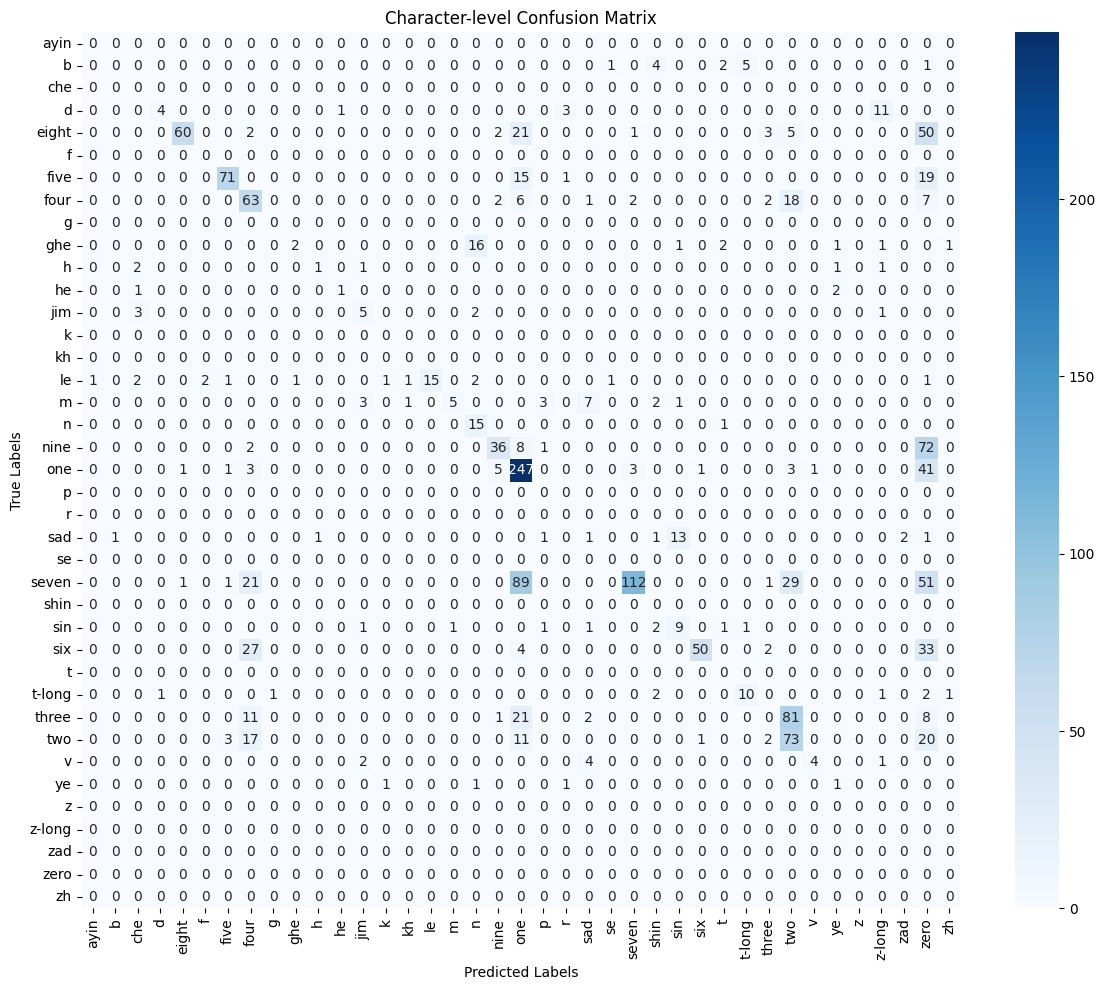

In [17]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_labels(filepath):
    data = {}
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            plate_id = int(parts[0])
            chars = parts[1:]
            data[plate_id] = chars
    return data

predicted = load_labels('predicted_plates.txt')
ground_truth = load_labels('plate_labels (1).txt')

all_labels = set()
for chars in predicted.values():
    all_labels.update(chars)
for chars in ground_truth.values():
    all_labels.update(chars)

all_labels = sorted(all_labels)
label_to_index = {label: i for i, label in enumerate(all_labels)}
matrix = np.zeros((len(all_labels), len(all_labels)), dtype=int)

true_positives = 0
total_predicted = 0
total_ground_truth = 0
correct_plates = 0
total_plates = 0

PAD = "<PAD>"

for pid, gt_chars in ground_truth.items():
    if pid in predicted:
        pred_chars = predicted[pid]
        len_gt = len(gt_chars)
        len_pred = len(pred_chars)

        total_predicted += len_pred
        total_ground_truth += len_gt

        if len_pred < len_gt:
            pad_len = len_gt - len_pred
            left_padded = pred_chars + [PAD] * pad_len
            right_padded = [PAD] * pad_len + pred_chars

            left_match = sum(p == g for p, g in zip(left_padded, gt_chars))
            right_match = sum(p == g for p, g in zip(right_padded, gt_chars))

            if right_match > left_match:
                best_pred = right_padded
            else:
                best_pred = left_padded
        else:
            best_pred = pred_chars

        for g, p in zip(gt_chars, best_pred):
            if p != PAD:
                i = label_to_index[g]
                j = label_to_index[p]
                matrix[i][j] += 1
                if g == p:
                    true_positives += 1

        trimmed_pred = [c for c in best_pred if c != PAD]
        if trimmed_pred == gt_chars:
            correct_plates += 1
        total_plates += 1

precision = true_positives / total_predicted if total_predicted else 0
recall = true_positives / total_ground_truth if total_ground_truth else 0
plate_accuracy = correct_plates / total_plates if total_plates else 0

# print(f'Character-level Precision: {precision:.2f}')
# print(f'Character-level Recall:    {recall:.2f}')
# print(f'Plate-level Accuracy:      {plate_accuracy:.2f}')

df_confusion = pd.DataFrame(matrix, index=all_labels, columns=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(df_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Character-level Confusion Matrix")
plt.tight_layout()
plt.show()

